In [10]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
from tqdm import tqdm
import emcee
import corner
import plotly.express as px
import plotly.graph_objects as go
import re
import glob
import statsmodels as sm

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from code import stats, utils
from code.outlier_detection import non_parametric, parametric
from code.fitting import numerical, analytical

## Comparison of outlier detection and fitting methods

### Examples

#### HAT-P-1

Non parametric methods: with and w/o considering measurement errors

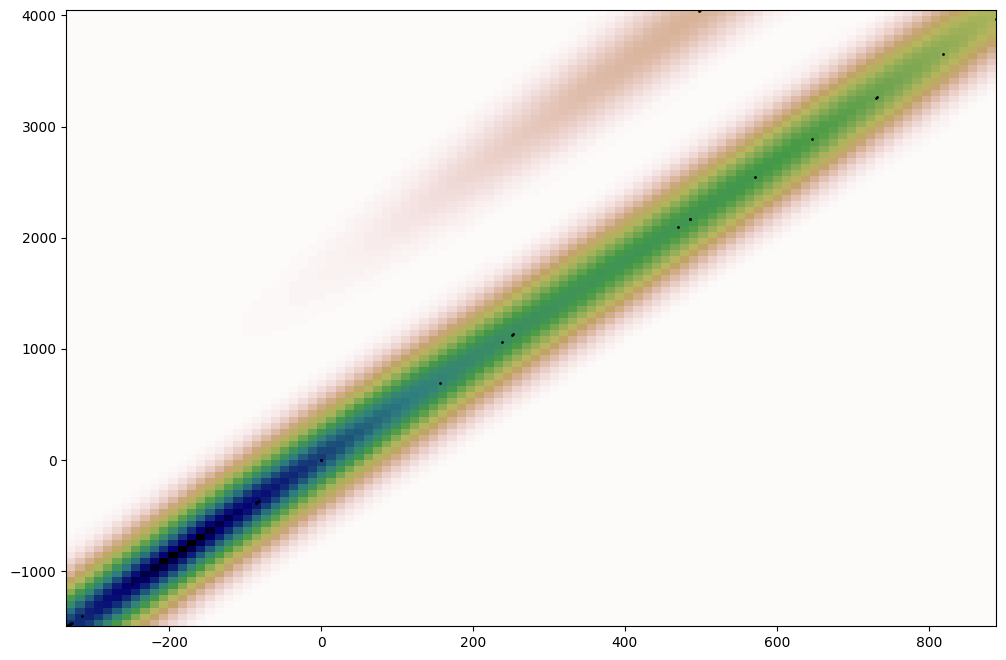

In [689]:
df = utils.load_data("./data/ORIGINALS/ETD_HAT-P-1_og.txt")

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, df.transit_time]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = df.transit_time.min()
ymax = df.transit_time.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax], aspect="auto")
ax.plot(df.epoch, df.transit_time, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

Parametric methods:

Text(0, 0.5, 'Transit time [BJD]')

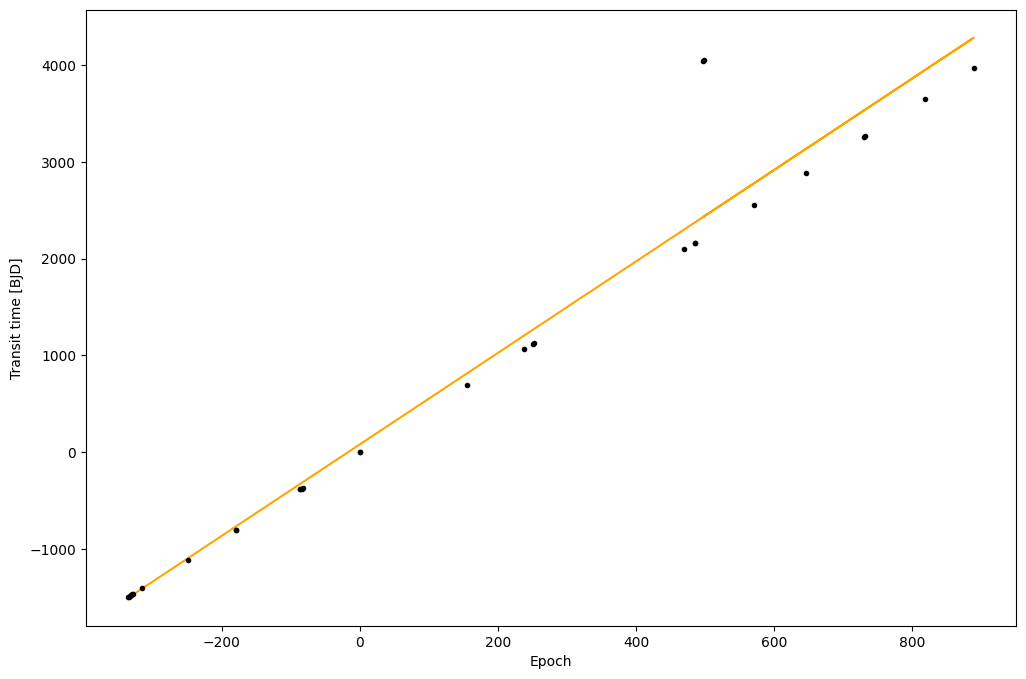

In [690]:
sigma_threshold = 5
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
lower_bound = df.transit_time - (df.error * sigma_threshold)
upper_bound = df.transit_time + (df.error * sigma_threshold)

# remove datapoints where the model fit does not lie within the datapoint's 5 sigma error
accepted = (lower_bound < y_hat) & (y_hat < upper_bound)
outliers = df[~accepted]
survivors = df[accepted]

plt.plot(df.epoch, y_hat, color="orange")
plt.errorbar(df.epoch, df.transit_time, yerr=df.error, fmt=".k", capsize=0)
plt.xlabel("Epoch")
plt.ylabel("Transit time [BJD]")

Parametric w/o considering measurement error:

Sensitive to number of datapoints

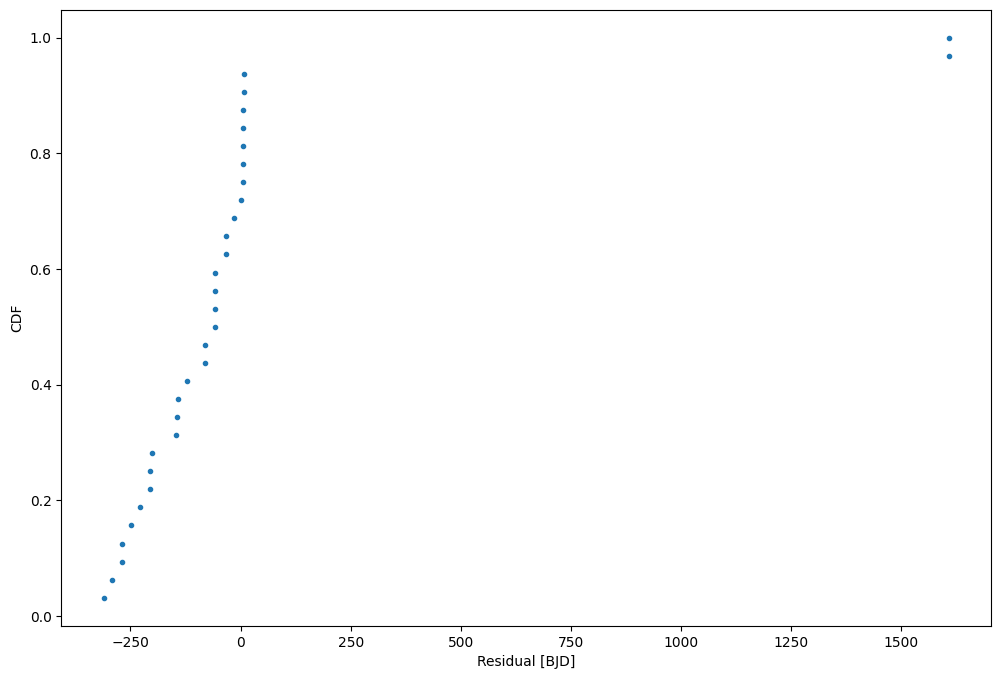

In [691]:
residuals = (y.flatten() - y_hat.flatten())
ecdf = sm.distributions.empirical_distribution.ECDF(residuals)
cumulative_prob = ecdf(residuals)
plt.scatter(residuals, cumulative_prob, marker=".")
plt.ylabel("CDF")
plt.xlabel("Residual [BJD]")
plt.show()

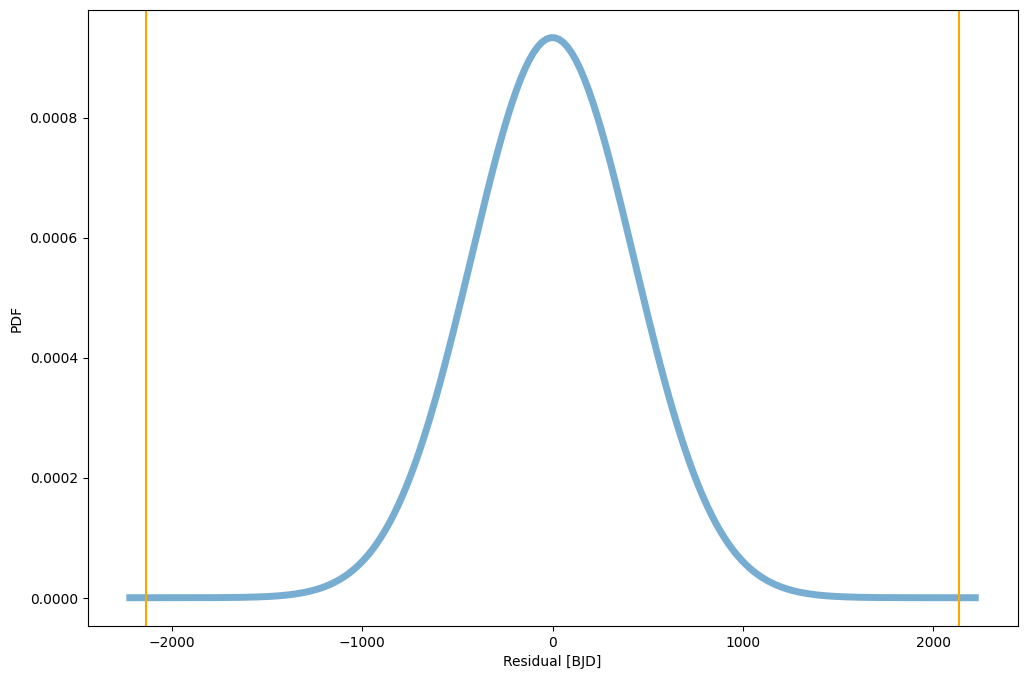

In [692]:
mean, std = sp.stats.norm.fit(residuals)
norm = sp.stats.norm(mean, std)
x = np.linspace(norm.ppf(1e-7), norm.ppf(1-1e-7), 200)
plt.plot(x, norm.pdf(x), lw=5, alpha=0.6, label='norm pdf')
plt.axvline(-sigma_threshold*std, color="orange")
plt.axvline(sigma_threshold*std, color="orange")
plt.xlabel("Residual [BJD]")
plt.ylabel("PDF")
plt.show()

#### WASP-19

Non parametric methods: with and w/o considering measurement errors

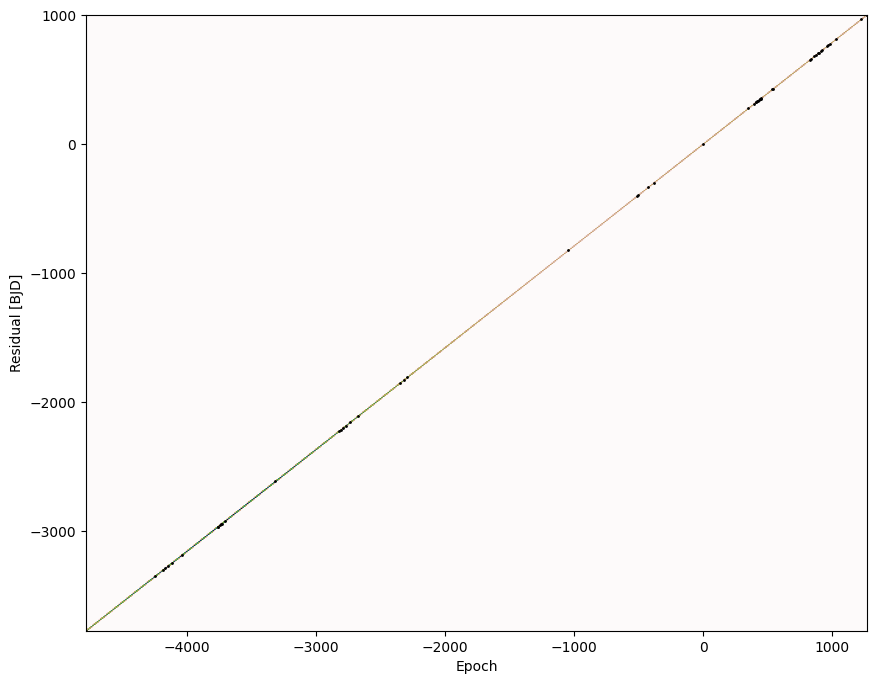

In [693]:
df = utils.load_data("./data/ORIGINALS/ETD_WASP-19_og.txt")

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, df.transit_time]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = df.transit_time.min()
ymax = df.transit_time.max()
X, Y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(df.epoch, df.transit_time, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel("Epoch")
plt.ylabel("Residual [BJD]")
plt.show()

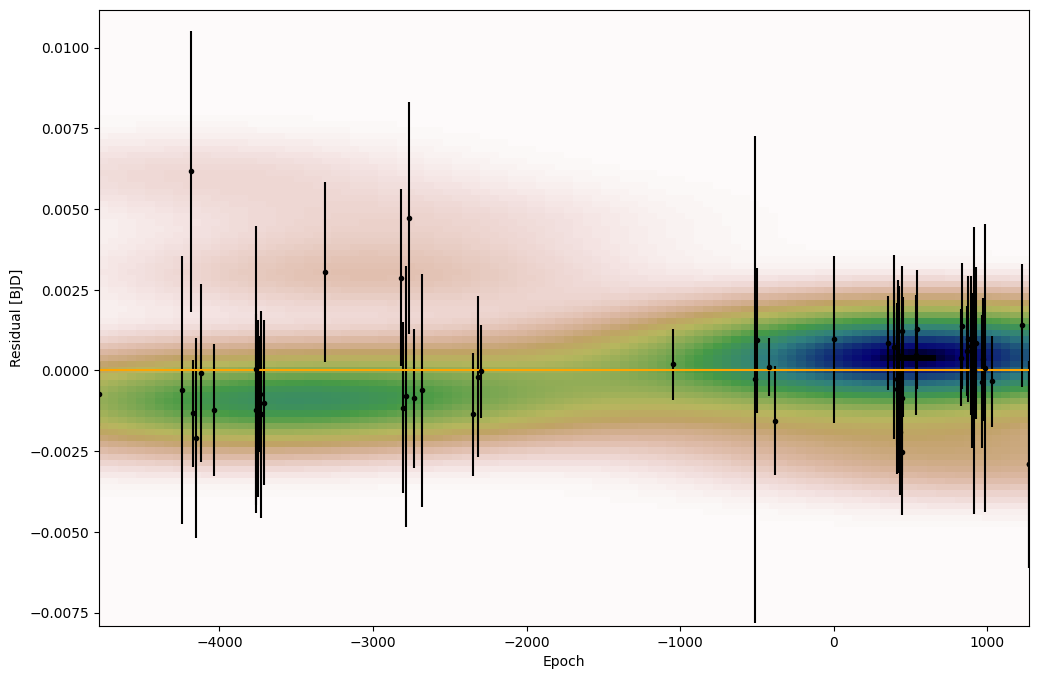

In [695]:
df = utils.load_data("./data/ORIGINALS/ETD_WASP-19_og.txt")

X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
residuals = (y.flatten() - y_hat.flatten())

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, residuals]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = residuals.min() - 0.005
ymax = residuals.max() + 0.005
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax], aspect="auto")
plt.errorbar(df.epoch, residuals, yerr=sigma_threshold*df.error, fmt=".k", capsize=0)
plt.axhline(0, color="orange")
plt.ylabel("Residual [BJD]")
plt.xlabel("Epoch")
plt.show()

Parametric methods:

Text(0, 0.5, 'Residual [BJD]')

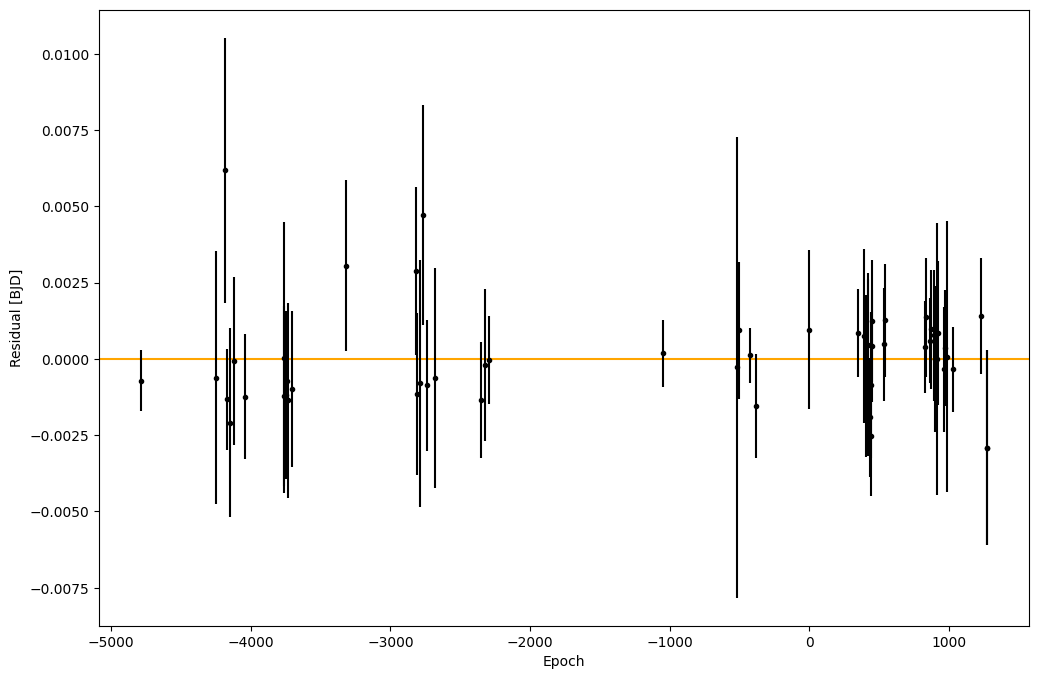

In [697]:
sigma_threshold = 5
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
lower_bound = df.transit_time - (df.error * sigma_threshold)
upper_bound = df.transit_time + (df.error * sigma_threshold)

# remove datapoints where the model fit does not lie within the datapoint's 5 sigma error
accepted = (lower_bound < y_hat) & (y_hat < upper_bound)
outliers = df[~accepted]
survivors = df[accepted]

residuals = (y.flatten() - y_hat.flatten())
plt.axhline(0, color="orange")
plt.errorbar(df.epoch, residuals, yerr=sigma_threshold*df.error, fmt=".k", capsize=0)
plt.xlabel("Epoch")
plt.ylabel("Residual [BJD]")

Parametric w/o considering measurement error:

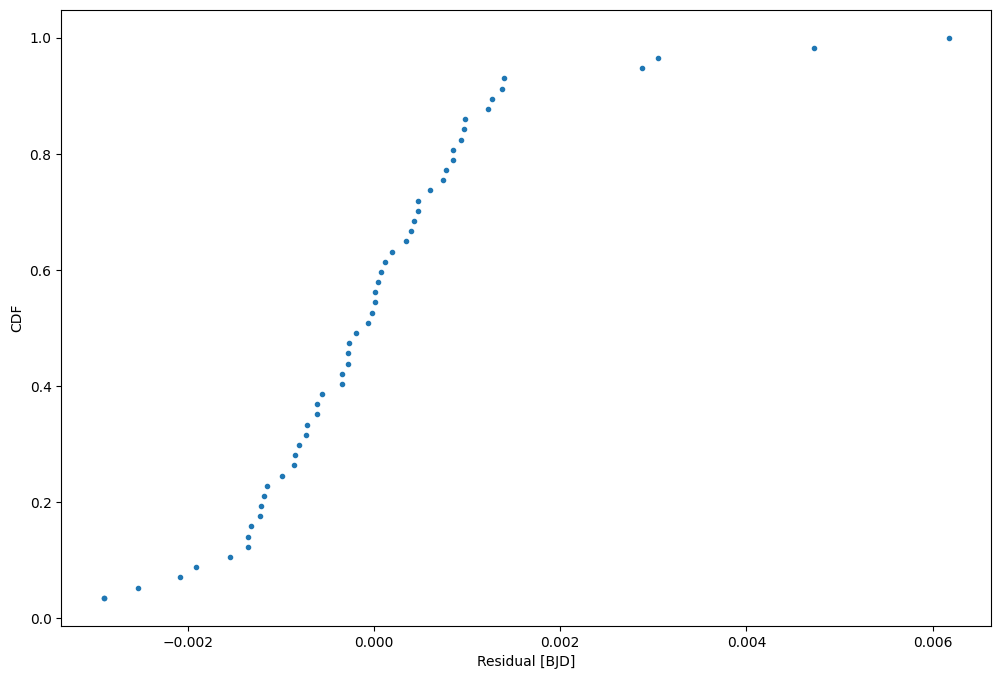

In [698]:
ecdf = sm.distributions.empirical_distribution.ECDF(residuals)
cumulative_prob = ecdf(residuals)
plt.scatter(residuals, cumulative_prob, marker=".")
plt.xlabel("Residual [BJD]")
plt.ylabel("CDF")
plt.show()

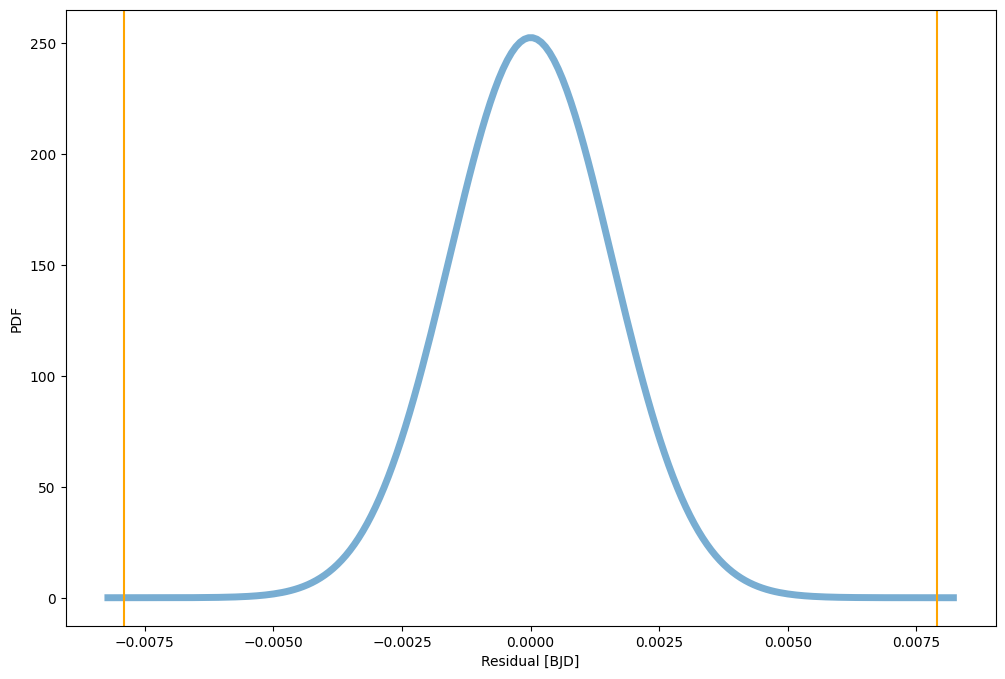

In [699]:
mean, std = sp.stats.norm.fit(residuals)
norm = sp.stats.norm(mean, std)
x = np.linspace(norm.ppf(1e-7), norm.ppf(1-1e-7), 200)
plt.plot(x, norm.pdf(x), lw=5, alpha=0.6, label='norm pdf')
plt.axvline(-sigma_threshold*std, color="orange")
plt.axvline(sigma_threshold*std, color="orange")
plt.xlabel("Residual [BJD]")
plt.ylabel("PDF")
plt.show()

#### WASP-12

Non parametric methods: with and w/o considering measurement errors

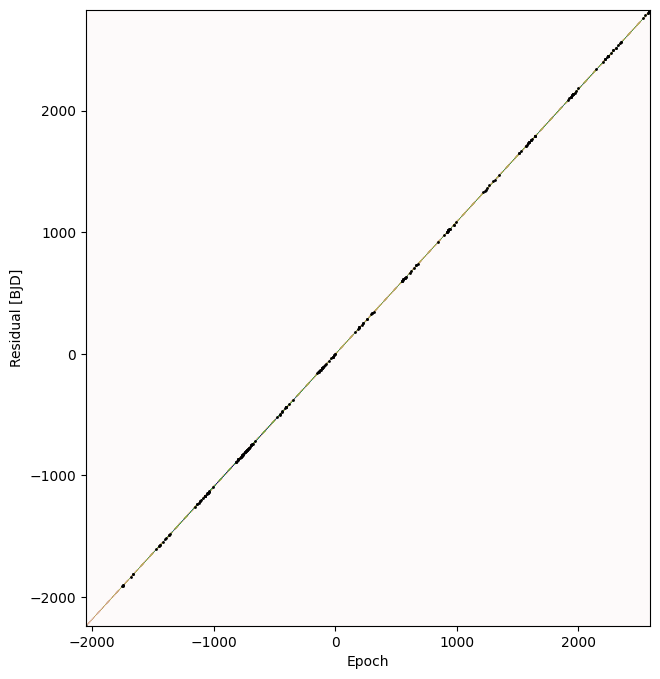

In [4]:
df = utils.load_data("./data/ORIGINALS/ETD_WASP-12_og.txt")

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, df.transit_time]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = df.transit_time.min()
ymax = df.transit_time.max()
X, Y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(df.epoch, df.transit_time, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlabel("Epoch")
plt.ylabel("Residual [BJD]")
plt.show()

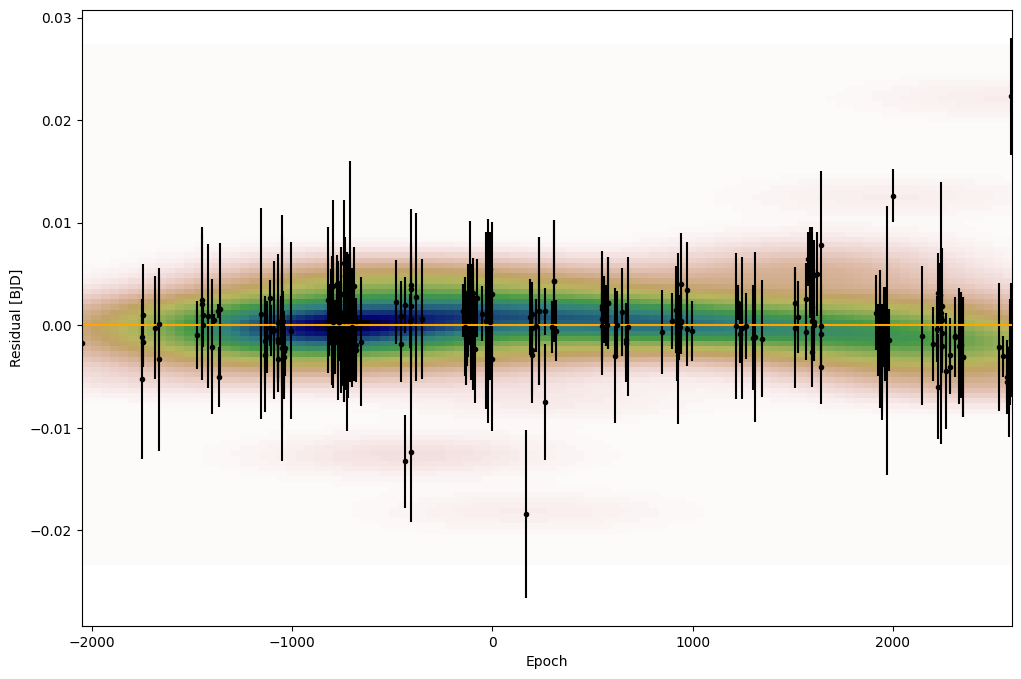

In [6]:
df = utils.load_data("./data/ORIGINALS/ETD_WASP-12_og.txt")
sigma_threshold = 5

X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
residuals = (y.flatten() - y_hat.flatten())

kernel = sp.stats.gaussian_kde(np.vstack([df.epoch, residuals]))

xmin = df.epoch.min()
xmax = df.epoch.max()
ymin = residuals.min() - 0.005
ymax = residuals.max() + 0.005
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax], aspect="auto")
plt.errorbar(df.epoch, residuals, yerr=sigma_threshold*df.error, fmt=".k", capsize=0)
plt.axhline(0, color="orange")
plt.ylabel("Residual [BJD]")
plt.xlabel("Epoch")
plt.show()

Parametric methods:

Text(0, 0.5, 'Residual [BJD]')

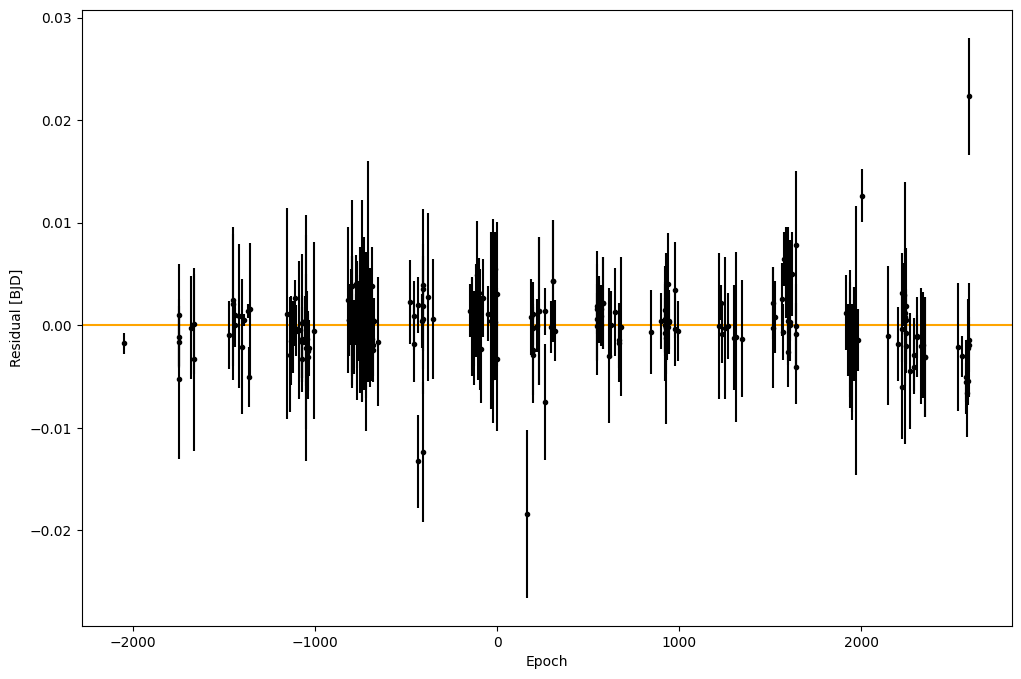

In [11]:
sigma_threshold = 5
X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0)
        # do not use a decay term
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
y_hat = (X @ beta).flatten()
lower_bound = df.transit_time - (df.error * sigma_threshold)
upper_bound = df.transit_time + (df.error * sigma_threshold)

# remove datapoints where the model fit does not lie within the datapoint's 5 sigma error
accepted = (lower_bound < y_hat) & (y_hat < upper_bound)
outliers = df[~accepted]
survivors = df[accepted]

residuals = (y.flatten() - y_hat.flatten())
plt.axhline(0, color="orange")
plt.errorbar(df.epoch, residuals, yerr=sigma_threshold*df.error, fmt=".k", capsize=0)
plt.xlabel("Epoch")
plt.ylabel("Residual [BJD]")

Parametric w/o considering measurement error:

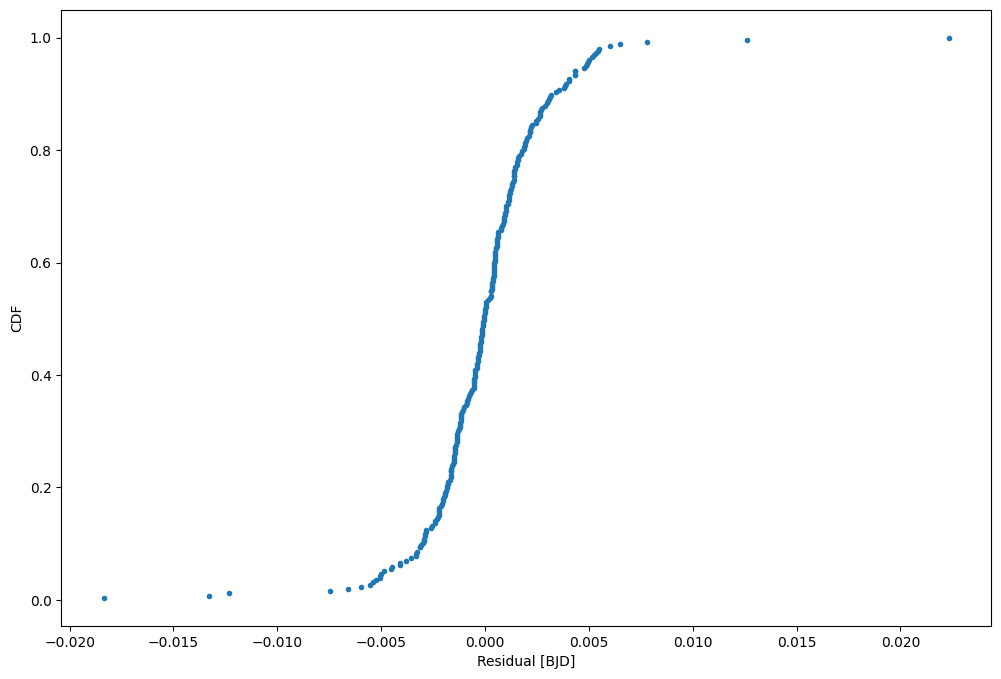

In [19]:
from statsmodels import distributions

ecdf = sm.distributions.empirical_distribution.ECDF(residuals)
cumulative_prob = ecdf(residuals)
plt.scatter(residuals, cumulative_prob, marker=".")
plt.xlabel("Residual [BJD]")
plt.ylabel("CDF")
plt.show()

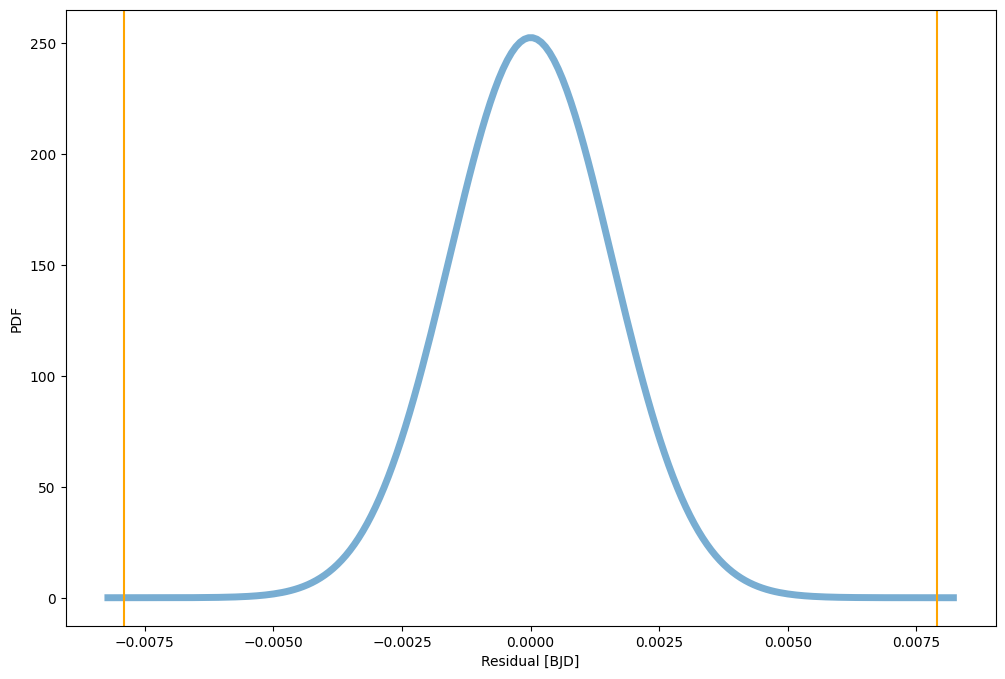

In [699]:
mean, std = sp.stats.norm.fit(residuals)
norm = sp.stats.norm(mean, std)
x = np.linspace(norm.ppf(1e-7), norm.ppf(1-1e-7), 200)
plt.plot(x, norm.pdf(x), lw=5, alpha=0.6, label='norm pdf')
plt.axvline(-sigma_threshold*std, color="orange")
plt.axvline(sigma_threshold*std, color="orange")
plt.xlabel("Residual [BJD]")
plt.ylabel("PDF")
plt.show()

### Comparison

In [21]:
outlier_detection_methods = [non_parametric.non_parametric_with_error, non_parametric.non_parametric_without_error, parametric.parametric_with_error, parametric.parametric_without_error, parametric.parametric_without_error_assuming_normality, None]
fitting_methods = [numerical.ml_fit, analytical.bayesian_mvn_regression_fit]

In [22]:
results = []

# running for all planets
files = glob.glob("./data/ORIGINALS/*.txt")

for file in tqdm(files):
    df = utils.load_data(file)
    planet = re.search("ETD_(.*)_og.txt", file).group(1)

    for outlier_detection_method in outlier_detection_methods:
        if outlier_detection_method is None:
            survivors = df
        else:
            survivors, _ = outlier_detection_method(df)

        fraction_outliers = 1 - (len(survivors) / len(df))

        for fitting_method in fitting_methods:
            try:
                beta, errors, k = fitting_method(survivors)
            except Exception:
                continue

            residuals = stats.compute_residuals(survivors, beta)
            normalised_residuals = residuals / errors
            
            try:
                normal_test_p_value = sp.stats.normaltest(normalised_residuals).pvalue
            except ValueError:  # fewer than 8 samples
                normal_test_p_value = None
            
            X2 = np.power(normalised_residuals, 2.0).sum()
            chi2_test_p_value = sp.stats.chi2(df=len(survivors)).sf(X2)

            bic = stats.bic(survivors, beta, k)
            
            results.append({
                "planet": planet,
                "outlier_detection": bool(outlier_detection_method) and outlier_detection_method.__name__,
                "fitting_method": fitting_method.__name__,
                "fraction_outliers": fraction_outliers,
                "normal_test_p_value": normal_test_p_value,
                "chi2_test_p_value": chi2_test_p_value,
                "bic": bic,
            })

  0%|                                                    | 0/71 [00:00<?, ?it/s]/usr/local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lawrence/Documents/University/Astrophysics/Project/code/stats.py:48: RuntimeWarning: divide by zero encountered in log
  return k * np.log(n) - 2 * log_likelihood(df, beta)
/usr/local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(ax

In [23]:
df = pd.DataFrame(data=results).sort_values("bic").dropna()
df

,planet,outlier_detection,fitting_method,fraction_outliers,normal_test_p_value,chi2_test_p_value,bic
339,TrES-3,parametric_with_error,bayesian_mvn_regression_fit,0.068817,7.458932e-01,2.784122e-105,-1.411235e+03
363,Qatar-1,parametric_with_error,bayesian_mvn_regression_fit,0.055156,7.044198e-01,2.347489e-119,-1.183375e+03
207,TrES-5,parametric_with_error,bayesian_mvn_regression_fit,0.038627,3.330893e-01,1.039899e-45,-8.835794e+02
807,TrES-2,parametric_with_error,bayesian_mvn_regression_fit,0.062963,9.710272e-01,2.771044e-76,-8.096901e+02
303,TrES-1,parametric_with_error,bayesian_mvn_regression_fit,0.059172,2.052556e-01,2.725155e-31,-7.691137e+02
650,HAT-P-37,parametric_with_error,ml_fit,0.025862,2.846472e-04,7.418808e-78,-7.019710e+02
646,HAT-P-37,non_parametric_with_error,ml_fit,0.043103,2.619412e-07,6.582287e-78,-6.687956e+02
291,WASP-43,parametric_with_error,bayesian_mvn_regression_fit,0.123457,8.788801e-01,3.733284e-34,-6.626559e+02
819,WASP-52,parametric_with_error,bayesian_mvn_regression_fit,0.121429,2.786742e-01,9.140138e-25,-6.425590e+02
654,HAT-P-37,parametric_without_error_assuming_normality,ml_fit,0.017241,5.906465e-04,1.183593e-90,-6.419065e+02


Comparing the fitting methods, we see they are similar in terms of BIC (in fact Bayesian MVN is slightly worse, likely due to the large increase in number of parameters), but Bayesian MVN is significant better in terms of normality of residuals in both the normal test and the Chi-squared test.

(Note a bigger p value and a smaller bic is better. The lower the p-value, the greater the statistical significance.)

In [96]:
# compare fitting methods
df.groupby("fitting_method").mean(numeric_only=True).sort_values("normal_test_p_value", ascending=False)

,fraction_outliers,normal_test_p_value,chi2_test_p_value,bic
fitting_method,,,,
bayesian_mvn_regression_fit,0.060826,0.204418,2.116806e-03,8.940974e+10
ml_fit,0.060826,0.116747,1.055119e-08,8.567145e+10


<AxesSubplot: title={'center': 'Relative performance of Bayesian regression vs maximum likelihood (MCMC) fit'}, xlabel='Test', ylabel='Relative performance'>

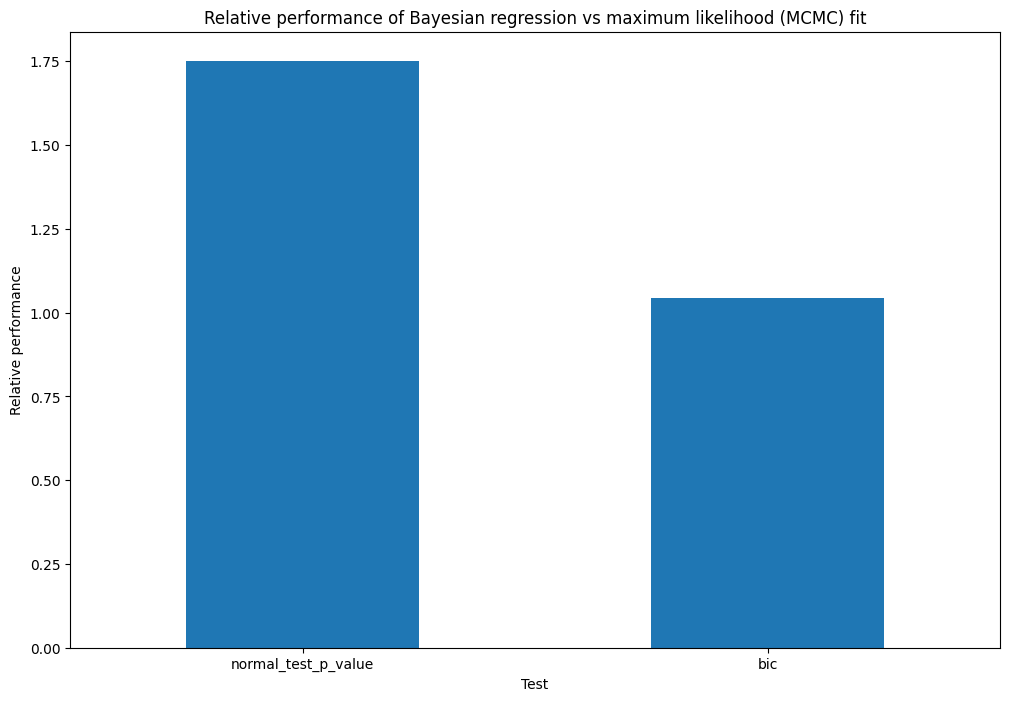

In [97]:
grouped = df.groupby("fitting_method").mean(numeric_only=True)
grouped = grouped / grouped.loc["ml_fit"]
grouped = grouped.drop(columns=["chi2_test_p_value", "fraction_outliers"])
grouped.loc["bayesian_mvn_regression_fit"].plot.bar(rot=0, xlabel="Test", ylabel="Relative performance", title="Relative performance of Bayesian regression vs maximum likelihood (MCMC) fit")

<AxesSubplot: title={'center': 'Relative performance of Bayesian regression vs maximum likelihood (MCMC) fit'}, xlabel='Test', ylabel='Relative performance'>

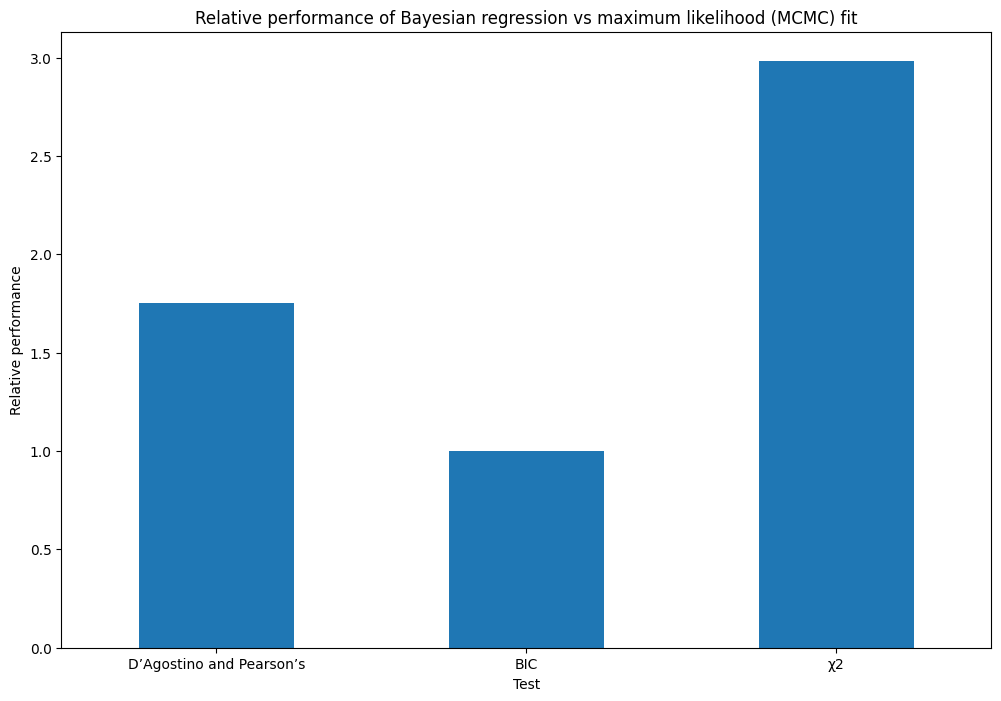

In [99]:
grouped = df.groupby("fitting_method").mean(numeric_only=True)
grouped["D’Agostino and Pearson’s"] = grouped.normal_test_p_value
grouped["BIC"] = 1/np.log(grouped.bic)
grouped["χ2"] = 1/np.log(grouped.chi2_test_p_value)
grouped = grouped / grouped.loc["ml_fit"]
grouped = grouped.drop(columns=["normal_test_p_value", "bic", "chi2_test_p_value", "fraction_outliers"])
grouped.loc["bayesian_mvn_regression_fit"].plot.bar(rot=0, xlabel="Test", ylabel="Relative performance", title="Relative performance of Bayesian regression vs maximum likelihood (MCMC) fit")

Very clear results from the outlier detection test. Using the reported errors greatly improves both normality and BIC goodness of fit.

Interestingly, even the non-parametric method using the reported errors was better than the parametric method without errors. I'm inclined to use the non-parametric method with error in the future, since there is no risk of "clipping" or inducing false signals based on the model.

In [100]:
# compare outlier detection methods
df.groupby("outlier_detection").mean(numeric_only=True).sort_values("normal_test_p_value", ascending=False)

,fraction_outliers,normal_test_p_value,chi2_test_p_value,bic
outlier_detection,,,,
parametric_with_error,0.143882,0.337640,1.901718e-04,2.905769e+04
non_parametric_with_error,0.205304,0.158147,6.282992e-03,3.303301e+04
parametric_without_error_assuming_normality,0.006348,0.131495,7.649880e-11,1.539592e+11
parametric_without_error,0.015832,0.130716,1.877539e-10,5.843387e+10
False,0.000000,0.105207,2.931732e-12,1.539593e+11
non_parametric_without_error,0.000000,0.105207,2.931732e-12,1.539593e+11


<AxesSubplot: title={'center': 'Relative performance of outlier methods vs a baseline of no outlier detection'}, xlabel='Test', ylabel='Relative performance'>

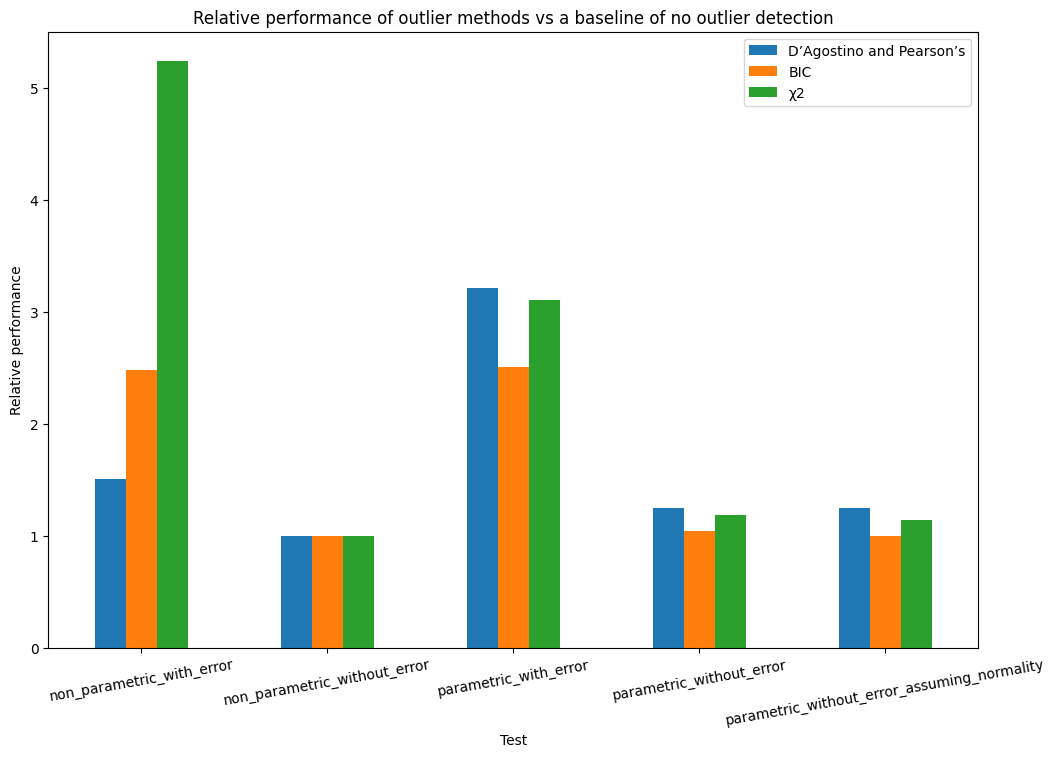

In [104]:
grouped = df.groupby("outlier_detection").mean(numeric_only=True)
grouped["D’Agostino and Pearson’s"] = grouped.normal_test_p_value
grouped["BIC"] = 1/np.log(grouped.bic)
grouped["χ2"] = 1/np.log(grouped.chi2_test_p_value)
grouped = grouped / grouped.iloc[0]  # the no outlier detection row
grouped = grouped.drop(columns=["normal_test_p_value", "bic", "chi2_test_p_value", "fraction_outliers"], index=False)
grouped.plot.bar(rot=10, xlabel="Test", ylabel="Relative performance", title="Relative performance of outlier methods vs a baseline of no outlier detection")

How many times each outlier detection/fitting method the best one?

In [556]:
df.loc[df.groupby("planet").normal_test_p_value.idxmax()].groupby(["outlier_detection"]).size()

outlier_detection
False                                           1
non_parametric_with_error                      13
non_parametric_without_error                    1
parametric_with_error                          45
parametric_without_error                        7
parametric_without_error_assuming_normality     4
dtype: int64

In [557]:
df.loc[df.groupby("planet").normal_test_p_value.idxmax()].groupby(["fitting_method"]).size()

fitting_method
bayesian_mvn_regression_fit    48
ml_fit                         23
dtype: int64

In [558]:
df.loc[df.groupby("planet").chi2_test_p_value.idxmax()].groupby(["outlier_detection"]).size()

outlier_detection
non_parametric_with_error                       9
parametric_with_error                          55
parametric_without_error                        5
parametric_without_error_assuming_normality     2
dtype: int64

In [559]:
df.loc[df.groupby("planet").chi2_test_p_value.idxmax()].groupby(["fitting_method"]).size()

fitting_method
bayesian_mvn_regression_fit    60
ml_fit                         11
dtype: int64

In [20]:
df.hist(column="normal_test_p_value", by="fitting_method", bins=100, log=True)

KeyError: 'fitting_method'

array([[<AxesSubplot: title={'center': 'False'}>,
        <AxesSubplot: title={'center': 'non_parametric_with_error'}>],
       [<AxesSubplot: title={'center': 'non_parametric_without_error'}>,
        <AxesSubplot: title={'center': 'parametric_with_error'}>],
       [<AxesSubplot: title={'center': 'parametric_without_error'}>,
        <AxesSubplot: title={'center': 'parametric_without_error_assuming_normality'}>]],
      dtype=object)

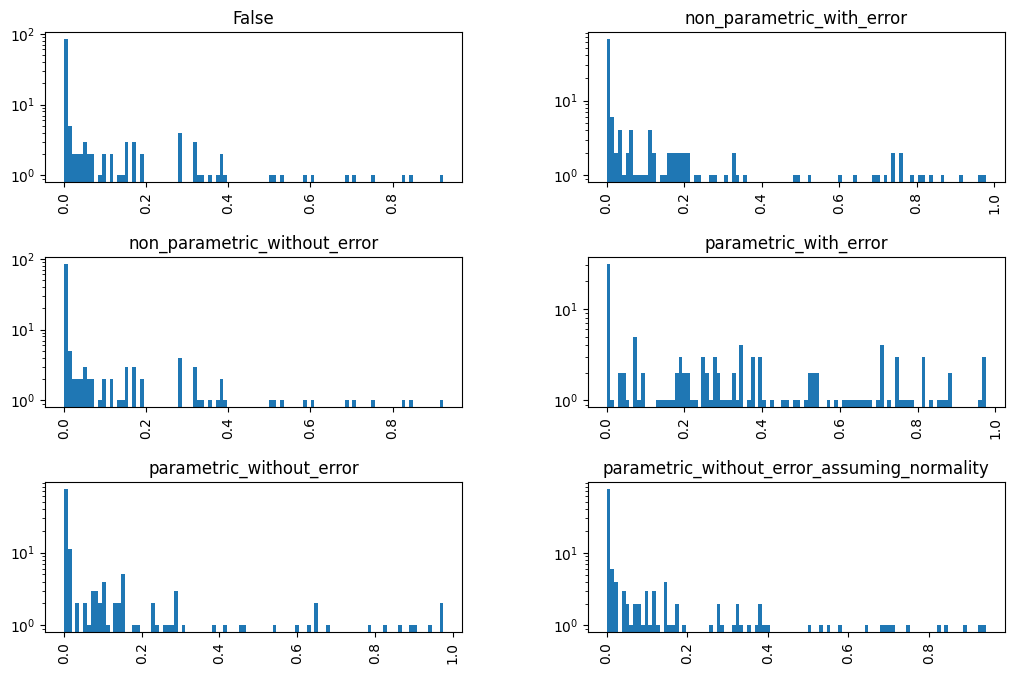

In [561]:
df.hist(column="normal_test_p_value", by="outlier_detection", bins=100, log=True)

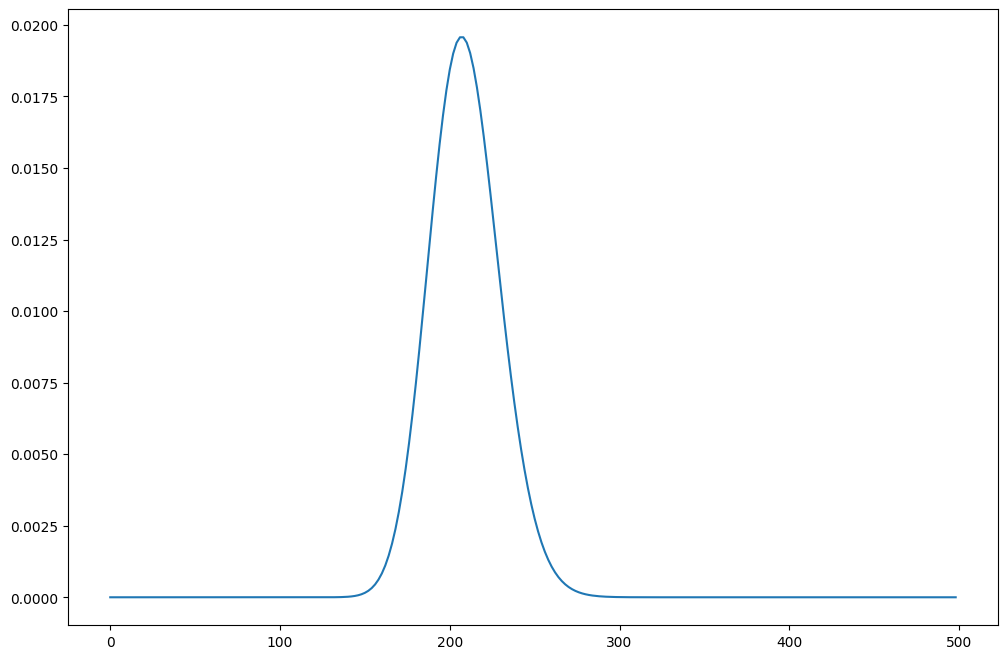

In [250]:
X = np.arange(0, 500, 2)
plt.plot(X, sp.stats.chi2(df=len(survivors)).pdf(X))